## Personal Attributes

### Importing Libs

In [ ]:
#if running in colab
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

In [1]:
import sklearn

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import keras
import cv2,json
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import keras.backend as K
from keras.layers import Conv2D,Dense,Flatten,Activation,BatchNormalization,Add,Concatenate,Input
from keras.layers import GlobalMaxPooling2D,GlobalAveragePooling2D,MaxPooling2D,Dropout
from albumentations import Compose,RandomCrop,RandomGamma,HueSaturationValue
from albumentations import HorizontalFlip,RandomContrast,ShiftScaleRotate,RandomBrightness
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
from keras.models import Model,load_model
from keras.utils import plot_model
import pydot
import tensorflow as tf
import math
from keras.applications import VGG16
from sklearn.utils import class_weight
import skimage

Using TensorFlow backend.


### Data set reading 

In [4]:
data = pd.read_csv("hvc_annotations.csv")

In [5]:
data.head()

,filename,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,images/Set1/5580_2 (3).jpg,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,images/Set1/4650_1 (4).jpg,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,images/Set1/44880_0.jpg,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,images/Set1/26130_2.jpg,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,images/Set1/IMG (4438).jpg,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [6]:
one_hot_df = pd.concat([data['image_path'],pd.get_dummies(data['gender'],prefix='gender'),
                       pd.get_dummies(data['imagequality'],prefix='imagequality'),
                       pd.get_dummies(data['age'],prefix='age'),
                       pd.get_dummies(data['weight'],prefix='weight'),
                       pd.get_dummies(data['carryingbag'],prefix='carryingbag'),
                       pd.get_dummies(data['footwear'],prefix='footwear'),
                       pd.get_dummies(data['emotion'],prefix='emotion'),
                       pd.get_dummies(data['bodypose'],prefix='bodypose')],axis=1)

In [7]:
one_hot_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,...,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
0,resized/1.jpg,0,1,1,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,1,0
1,resized/2.jpg,1,0,1,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,1,0
2,resized/3.jpg,0,1,0,0,1,0,0,0,1,...,1,0,0,0,0,1,0,0,1,0
3,resized/4.jpg,0,1,0,0,1,0,0,0,1,...,0,0,1,0,0,1,0,0,1,0
4,resized/5.jpg,1,0,0,0,1,0,0,1,0,...,1,0,0,0,0,1,0,0,1,0


In [8]:
train_df, val_df = train_test_split(one_hot_df, test_size=0.15,random_state=42)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [9]:
train_df.reset_index(inplace=True,drop=True)
val_df.reset_index(inplace=True,drop=True)

###  Baseline classifiers
Predicting most frequent class for every output

In [10]:
print(f"Baseline accuracy for age:  {data['age'].value_counts(normalize=True).max()}")
print(f"Baseline accuracy for gender:  {data['gender'].value_counts(normalize=True).max()}")
print(f"Baseline accuracy for imagequality:  {data['imagequality'].value_counts(normalize=True).max()}")
print(f"Baseline accuracy for weight:  {data['weight'].value_counts(normalize=True).max()}")
print(f"Baseline accuracy for carryingbag:  {data['carryingbag'].value_counts(normalize=True).max()}")
print(f"Baseline accuracy for footwear:  {data['footwear'].value_counts(normalize=True).max()}")
print(f"Baseline accuracy for emotion:  {data['emotion'].value_counts(normalize=True).max()}")
print(f"Baseline accuracy for bodypose:  {data['bodypose'].value_counts(normalize=True).max()}")

Baseline accuracy for age:  0.39865910263022175
Baseline accuracy for gender:  0.5625874898695941
Baseline accuracy for imagequality:  0.5532306785530097
Baseline accuracy for weight:  0.6356737640904737
Baseline accuracy for carryingbag:  0.56354527370515
Baseline accuracy for footwear:  0.4448537537758786
Baseline accuracy for emotion:  0.7117070654976793
Baseline accuracy for bodypose:  0.6176232225742282


### DataGenerators 

In [11]:
_age_cols_=[col for col in train_df.columns if col.startswith('age')]
_imagequality_cols_=[col for col in train_df.columns if col.startswith('imagequality')]
_gender_cols_=[col for col in train_df.columns if col.startswith('gen')]
_weight_cols_=[col for col in train_df.columns if col.startswith('wei')]
_carryingbag_cols_=[col for col in train_df.columns if col.startswith('carry')]
_footwear_cols_=[col for col in train_df.columns if col.startswith('foot')]
_emotion_cols_=[col for col in train_df.columns if col.startswith('emotion')]
_bodypose_cols_=[col for col in train_df.columns if col.startswith('bodypose')]

In [12]:
augmentations = Compose([HorizontalFlip(p=0.5),RandomContrast(limit=0.2, p=0.5)
                         ,RandomGamma(gamma_limit=(80, 120), p=0.5),RandomBrightness(limit=0.2, p=0.5),
                        HueSaturationValue(hue_shift_limit=5, sat_shift_limit=20,val_shift_limit=10, p=.9),
                        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1,rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.8)])

In [13]:
img = skimage.io.imread(train_df.image_path[0])

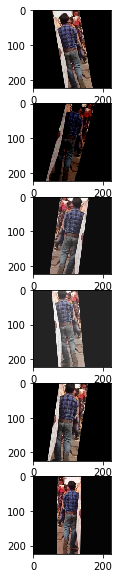

In [14]:
_,axs=plt.subplots(6,1,figsize=(16,10))
for i in range(6):
    axs[i].imshow(augmentations(image=img)["image"])

In [15]:
class PersonalAttributeGen(keras.utils.Sequence):
    def __init__(self,df,augment=augmentations,bs=32,mean=0,shuffle=True,std=1.):
        super().__init__()
        self.df=df
        self.shuffle=shuffle
        self.mean=mean
        self.std=std
        self.bs=bs
        self.augment=augment
        self.on_epoch_end()
    def __len__(self):
        return self.df.shape[0]//self.bs
    def __getitem__(self,idxs):
        batch_slice = slice(idxs*self.bs,(idxs+1)*self.bs)
        batch_data = self.df.iloc[batch_slice]
        if self.augment is not None:
            image_data = np.stack([self.augment(image=skimage.io.imread(img))["image"]/255. for img in batch_data.image_path])
        else:
            image_data = np.stack([skimage.io.imread(img)/255. for img in batch_data.image_path])
  
        target={'age_output':batch_data[_age_cols_].values,
               'gender_output':batch_data[_gender_cols_].values,
               'emotion_output':batch_data[_emotion_cols_].values,
               'footwear_output':batch_data[_footwear_cols_].values,
               'bodypose_output':batch_data[_bodypose_cols_].values,
               'weight_output':batch_data[_weight_cols_].values,
               'imagequality_output':batch_data[_imagequality_cols_].values,
               'carryingbag_output':batch_data[_carryingbag_cols_].values
               }
        #return batch_data
        return image_data,target
    def on_epoch_end(self):
        if self.shuffle:
            self.df=self.df.sample(frac=1).reset_index(drop=True)

In [16]:
train_gen = PersonalAttributeGen(train_df)

In [17]:
X,y=next(iter(train_gen))

In [18]:
num_units={}
for k,v in y.items():
    num_units[k.split('_output')[0]]=v.shape[1]

In [19]:
num_units

{'age': 5,
 'gender': 2,
 'emotion': 4,
 'footwear': 3,
 'bodypose': 3,
 'weight': 4,
 'imagequality': 3,
 'carryingbag': 3}

In [ ]:
# function to add label smoothing
def add_label_noise(y,noise_level=0.2,selected_cols=[]):
    def add_noise(x):
        temp = x*(1-noise_level)
        res = (np.asarray(([noise_level]*x.shape[1]))/x.shape[1]).reshape(1,-1)
        temp=temp+res
        return temp
    if len(selected_cols)==0:
        temp=add_noise(y)
    else:
        temp=y.copy()
        for c in selected_cols:
            temp[temp[c]==1] = add_noise(temp[temp[c]==1])  
    return temp

    

In [ ]:
data['weight'].value_counts(normalize=True)

In [ ]:
data.age.value_counts(normalize=True)

In [ ]:
train_df_ls = train_df.copy()
train_df_ls[_age_cols_]=add_label_noise(train_df_ls[_age_cols_],noise_level=0.3,selected_cols=['age_25-35'])
train_df_ls[_emotion_cols_]=add_label_noise(train_df_ls[_emotion_cols_],noise_level=0.4,selected_cols=['emotion_Neutral'])
train_df_ls[_weight_cols_]=add_label_noise(train_df_ls[_weight_cols_],noise_level=0.4,selected_cols=['weight_normal-healthy'])

In [ ]:
train_df_ls.head()

In [20]:
train_gen = PersonalAttributeGen(train_df,augment=augmentations)
val_gen = PersonalAttributeGen(val_df,bs=64,augment=None,shuffle=False)

In [ ]:
class MixUpGenerator(keras.utils.Sequence):
    def __init__(self,df,augment=augmentations,bs=32,shuffle=True,alpha=0.2):
        super().__init__()
        self.df=df
        self.idxs1 = np.arange(self.df.shape[0])
        self.idxs2 = np.arange(self.df.shape[0])
        self.shuffle=shuffle
        self.bs=bs
        self.augment=augment
        self.on_epoch_end()
        self.alpha=alpha
        
    def __len__(self):
        return self.df.shape[0]//self.bs
    
    def __getitem__(self,idxs):
        batch_slice = slice(idxs*self.bs,(idxs+1)*self.bs)
        batch_slice1 = self.idxs1[batch_slice]
        batch_slice2 = self.idxs2[batch_slice]
        batch_data1 = self.df.iloc[batch_slice1]
        batch_data2 = self.df.iloc[batch_slice2]
        bs = batch_data2.shape[0]
        l = np.random.beta(self.alpha,self.alpha,bs)
        #l=np.ones(bs,dtype='uint8')
        image_data1 = np.stack([skimage.io.imread(img)/255. for img in batch_data1.image_path])
        image_data2 = np.stack([skimage.io.imread(img)/255. for img in batch_data2.image_path])
        x_mult = l.reshape(bs,1,1,1)
        y_mult = l.reshape(bs,1)
        image_data = image_data1*x_mult+(1-x_mult)*image_data2
        #print(x_mult)
        target={'age_output':y_mult*batch_data1[_age_cols_].values+(1-y_mult)*batch_data2[_age_cols_].values,
               'gender_output':y_mult*batch_data1[_gender_cols_].values + (1-y_mult)*batch_data2[_gender_cols_].values,
               'emotion_output':y_mult*batch_data1[_emotion_cols_].values + (1-y_mult)*batch_data2[_emotion_cols_].values,
               'footwear_output':y_mult*batch_data1[_footwear_cols_].values + (1-y_mult)*batch_data2[_footwear_cols_].values,
               'bodypose_output':y_mult*batch_data1[_bodypose_cols_].values + (1-y_mult)*batch_data2[_bodypose_cols_].values,
               'weight_output':y_mult*batch_data1[_weight_cols_].values + (1-y_mult)*batch_data2[_weight_cols_].values,
               'imagequality_output':y_mult*batch_data1[_imagequality_cols_].values + (1-y_mult)*batch_data2[_imagequality_cols_].values,
               'carryingbag_output':y_mult*batch_data1[_carryingbag_cols_].values + (1-y_mult)*batch_data2[_carryingbag_cols_].values
               }
        #return batch_data
        #return image_data1,image_data2,image_data,l,target
        return image_data,target
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.idxs1)
            np.random.shuffle(self.idxs2)
            #self.df=self.df.sample(frac=1).reset_index(drop=True)

In [ ]:
train_gen = MixUpGenerator(train_df,augment=augmentations)


In [ ]:
X1,X2,X,l,y=next(iter(train_gen))

In [ ]:
plt.imshow(X2[3])

In [ ]:
plt.imshow(X1[3])

In [ ]:
plt.imshow(X[3].astype('uint8'))

### Model Layers 

In [21]:
def basic_conv(inp,nf=16,kernel_size=3,strides=1,padding='same',conv_first=True,bn=True,activation='relu',wd=1e-4,dropout=True,p=0.1,initialize_bn=False):
    if conv_first:
        x = Conv2D(filters=nf,kernel_size=kernel_size,strides=strides,padding=padding,kernel_initializer='he_normal',kernel_regularizer=keras.regularizers.l2(wd))(inp)
        if bn:
            if initialize_bn:
                x = BatchNormalization(gamma_initializer='zeros')(x)
            else:
                x = BatchNormalization()(x)
        x = Activation(activation)(x)
        if dropout:
            x=Dropout(rate=p)(x)
    else:
        if bn:
            x = BatchNormalization()(inp)
        x=Activation(activation)(x)
        x = Conv2D(filters=nf,kernel_size=kernel_size,strides=strides,padding=padding,kernel_initializer='he_normal',kernel_regularizer=keras.regularizers.l2(wd))(x)
        if dropout:
            x=Dropout(rate=p)(x)
    return x   

In [22]:
def build_bone(nf=32,n_stacks=3,n_resblocks=3,dropout=False,p=0.1,initialize_bn=False):
    inp = Input(shape=(224,224,3))
    x = basic_conv(inp,nf=nf,dropout=dropout,p=p)
    if nf<64:
        nf=nf*2
    x = basic_conv(x,nf=nf,dropout=dropout,p=p)
    x = MaxPooling2D()(x)
    x = basic_conv(x,nf=nf,dropout=dropout,p=p)
    x = MaxPooling2D()(x)
    for s in range(n_stacks):
        for j in range(n_resblocks):
            if s>0 and j==0:
                y = basic_conv(x,nf=nf,strides=2,dropout=dropout,p=p)
                x = basic_conv(x,nf=nf,kernel_size=1,strides=2,activation=None,bn=False)
            else:
                y = basic_conv(x,nf=nf,strides=1,dropout=dropout,p=p)
            if not initialize_bn:
                y = basic_conv(y,nf=nf,strides=1,activation=None)
            else:
                y =  basic_conv(y,nf=nf,strides=1,activation=None,initialize_bn=True)
            x = Add()([x,y])
            x = Activation('relu')(x)
        nf*=2
    out1 = GlobalAveragePooling2D()(x)
    out2 = GlobalMaxPooling2D()(x)
    out=Concatenate()([out1,out2])
    model = Model(inp,out)
    return model
                

In [ ]:
backbone=build_bone(n_resblocks=3,initialize_bn=True)

In [ ]:
backbone.summary()

In [ ]:
class lr_finder(keras.callbacks.Callback):
    def __init__(self,min_lr=1e-6,max_lr=5,max_loss=1e9,max_iters=1000,smooth=0.98,patience=10):
        self.min_lr,self.max_lr=min_lr,max_lr
        self.max_loss=max_loss
        self.max_iters=max_iters
        self.smooth=smooth
        self.patience=patience
        self.reset()
    def reset(self):
        self.min_loss=self.max_loss
        self.lr=self.min_lr
        self.rate = (self.max_lr/self.min_lr)**(1/self.max_iters)
        self.lrs=[]
        self.losses=[]
        self.wait=0
        self.iters=0
    def on_train_begin(self,logs={}):
        self.reset()
        K.set_value(self.model.optimizer.lr,self.lr)
        
    def on_batch_end(self,batch,logs={}):
        loss=logs['loss']
        self.iters+=1
        lr = K.get_value(self.model.optimizer.lr)
        self.lr = self.min_lr*(self.rate)**self.iters
        self.losses.append(loss)
        self.lrs.append(lr)
        if loss<self.min_loss:
            self.min_loss=loss
        elif  loss>self.min_loss*10 or self.iters>self.max_iters:
            self.model.stop_training=True
        K.set_value(self.model.optimizer.lr,self.lr)
    def on_epoch_end(self,epoch,logs={}):
        #pass
        print(self.lr,K.get_value(self.model.optimizer.lr))
    
    def plot(self,start=20,skip_last=100):
        loss_smooth=[]
        for l in self.losses:
            if len(loss_smooth)==0:
                loss_smooth.append((1-self.smooth)*l)
                continue
            loss_smooth.append(self.smooth*loss_smooth[-1]+(1-self.smooth)*l)
        plt.plot(self.lrs[start:-skip_last],loss_smooth[start:-skip_last])
        plt.xscale('log')
        plt.show()
        
        
    


In [27]:
class LR_scheduler(keras.callbacks.Callback):
    
    def __init__(self,min_lr=1e-6,max_lr=1e-2,steps=[0.4,0.9,1.],tot_batches=1000):
        self.min_lr,self.max_lr,self.steps,self.tot_batches=min_lr,max_lr,steps,tot_batches
        
    def reset(self):
        self.pos=0
        self.iters=0
        self.lrs=[]
        
    def on_train_begin(self,logs={}):
        self.reset()
        
    def on_epoch_end(self,epoch,logs={}):
        print(f"Epoch Number: {epoch}")
        print(f"Learning Rate: {K.get_value(self.model.optimizer.lr)}")

    def get_lr(self,mode="increasing"):
        if mode=='increasing':
            pos = self.pos/self.steps[0]
            #print(f"increasring: {self.pos}")
            self.lr = self.min_lr + (self.max_lr-self.min_lr)*pos
        elif mode=="decreasing":
            if self.pos<self.steps[1]:
                #print(f"\n {self.pos}")
                pos=(self.pos-self.steps[0])/(self.steps[1]-self.steps[0])
                self.lr = self.max_lr + (self.min_lr-self.max_lr)*pos
            else:
                pos = (self.pos-self.steps[1])/(self.steps[2]-self.steps[1])
                self.lr = self.min_lr + (self.min_lr-0.1*self.min_lr)*pos
                
    def on_batch_end(self,batch,logs={}):
        
        self.iters+=1
        self.pos = self.iters/self.tot_batches
        
        if self.pos<self.steps[0]:
            self.get_lr()
        else:
            self.get_lr(mode='decreasing')
        K.set_value(self.model.optimizer.lr,self.lr)
        self.lrs.append(K.get_value(self.model.optimizer.lr))
        

In [23]:
bone = build_bone(n_stacks=3,dropout=True,p=0.1)#,initialize_bn=True)
neck=bone.output
neck = Dense(256,kernel_initializer='he_normal',kernel_regularizer=keras.regularizers.l2(1e-4))(neck)
neck = BatchNormalization()(neck)
neck=Activation('relu')(neck)

def build_tower(neck,p=0.1,hids=[128,128]):
    x = Dropout(p)(neck)
    x = Dense(hids[0],kernel_initializer='he_normal',kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x=BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(p)(x)
    x = Dense(hids[1],kernel_initializer='he_normal',kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x=BatchNormalization()(x)
    x = Activation('relu')(x)
    return x
def build_head(tower,name):
    return Dense(num_units[name],activation='softmax',kernel_initializer='he_normal',name="{}_output".format(name))(tower)
age = build_head(build_tower(neck),"age")
image = build_head(build_tower(neck),"imagequality")
emotion = build_head(build_tower(neck),"emotion")
bag = build_head(build_tower(neck),"carryingbag")
weight = build_head(build_tower(neck),"weight")
foot = build_head(build_tower(neck),"footwear")
gender = build_head(build_tower(neck),"gender")
body = build_head(build_tower(neck),"bodypose")

model= Model(bone.input,outputs=[age,image,emotion,bag,weight,foot,gender,body]) 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [ ]:
losses={"age_output":"categorical_crossentropy","gender_output":"binary_crossentropy","footwear_output":"categorical_crossentropy","weight_output":"categorical_crossentropy"
       ,"bodypose_output":"categorical_crossentropy","carryingbag_output":"categorical_crossentropy","emotion_output":"categorical_crossentropy","imagequality_output":"categorical_crossentropy"}
opt = keras.optimizers.SGD(lr=0.001,momentum=0.9)
finder = lr_finder()
loss_weights={"age_output":3,"gender_output":1,"footwear_output":2,"bodypose_output":1,
             "carryingbag_output":3,"emotion_output":3,"imagequality_output":2,"weight_output":2}
model.compile(optimizer=opt,loss=losses,metrics=['accuracy'])#,loss_weights=loss_weights)

In [ ]:
model.fit_generator(generator=train_gen,validation_data=val_gen,use_multiprocessing=True,workers=6,verbose=1
                    ,callbacks=[finder],epochs=5)

In [ ]:
finder.plot(skip_last=1)

In [ ]:
import gc
del model
gc.collect()

### After finding learning rate
max_lr,min_lr=1e-2,1e-6

In [28]:
bone = build_bone(n_stacks=3,dropout=True,p=0.1)
neck=bone.output
neck = Dense(256,kernel_initializer='he_normal',kernel_regularizer=keras.regularizers.l2(1e-4))(neck)
neck = BatchNormalization()(neck)
neck=Activation('relu')(neck)

def build_tower(neck,p=0.1,hids=[128,128]):
    x = Dropout(p)(neck)
    x = Dense(hids[0],kernel_initializer='he_normal',kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x=BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(p)(x)
    x = Dense(hids[1],kernel_initializer='he_normal',kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x=BatchNormalization()(x)
    x = Activation('relu')(x)
    return x
def build_head(tower,name):
    return Dense(num_units[name],activation='softmax',kernel_initializer='he_normal',name="{}_output".format(name))(tower)
age = build_head(build_tower(neck),"age")
image = build_head(build_tower(neck),"imagequality")
emotion = build_head(build_tower(neck),"emotion")
bag = build_head(build_tower(neck),"carryingbag")
weight = build_head(build_tower(neck),"weight")
foot = build_head(build_tower(neck),"footwear")
gender = build_head(build_tower(neck),"gender")
body = build_head(build_tower(neck),"bodypose")

model= Model(bone.input,outputs=[age,image,emotion,bag,weight,foot,gender,body]) 

In [29]:
losses={"age_output":"categorical_crossentropy","gender_output":"binary_crossentropy","footwear_output":"categorical_crossentropy","weight_output":"categorical_crossentropy"
       ,"bodypose_output":"categorical_crossentropy","carryingbag_output":"categorical_crossentropy","emotion_output":"categorical_crossentropy","imagequality_output":"categorical_crossentropy"}
opt = keras.optimizers.SGD(lr=0.001,momentum=0.9)
loss_weights={"age_output":3,"gender_output":1,"footwear_output":2,"bodypose_output":1,
             "carryingbag_output":3,"emotion_output":3,"imagequality_output":2,"weight_output":2}
max_lr=1e-2
min_lr=5e-6
NEPOCHS=80
sched=LR_scheduler(max_lr=max_lr,min_lr=min_lr,tot_batches=NEPOCHS*len(train_gen),steps=[0.25,0.75,1.])

model.compile(optimizer=opt,loss=losses,metrics=['accuracy'])#,loss_weights=loss_weights)

In [30]:
hist=model.fit_generator(generator=train_gen,validation_data=val_gen,use_multiprocessing=True,workers=6,verbose=1
                    ,callbacks=[sched],epochs=NEPOCHS)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/80
  2/360 [..............................] - ETA: 32:21 - loss: 11.7135 - age_output_loss: 1.8818 - imagequality_output_loss: 1.0539 - emotion_output_loss: 1.4913 - carryingbag_output_loss: 1.2665 - weight_output_loss: 1.6823 - footwear_output_loss: 1.3184 - gender_output_loss: 0.7135 - bodypose_output_loss: 1.1975 - age_output_accuracy: 0.2500 - imagequality_output_accuracy: 0.4375 - emotion_output_accuracy: 0.3906 - carryingbag_output_accuracy: 0.3750 - weight_output_accuracy: 0.2188 - footwear_output_accuracy: 0.4062 - gender_output_accuracy: 0.6250 - bodypose_output_accuracy: 0.4219

/local/mnt/workspace/usr/rishubh/anaconda3/envs/eip/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.649952). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


360/360 [==============================] - 153s 424ms/step - loss: 10.4562 - age_output_loss: 1.6846 - imagequality_output_loss: 1.1170 - emotion_output_loss: 1.1446 - carryingbag_output_loss: 1.1050 - weight_output_loss: 1.2545 - footwear_output_loss: 1.1929 - gender_output_loss: 0.7824 - bodypose_output_loss: 1.0666 - age_output_accuracy: 0.2980 - imagequality_output_accuracy: 0.4654 - emotion_output_accuracy: 0.5908 - carryingbag_output_accuracy: 0.4658 - weight_output_accuracy: 0.4720 - footwear_output_accuracy: 0.3885 - gender_output_accuracy: 0.5126 - bodypose_output_accuracy: 0.5104 - val_loss: 9.3014 - val_age_output_loss: 1.5126 - val_imagequality_output_loss: 1.0299 - val_emotion_output_loss: 0.9304 - val_carryingbag_output_loss: 0.9379 - val_weight_output_loss: 1.0008 - val_footwear_output_loss: 1.0544 - val_gender_output_loss: 0.6987 - val_bodypose_output_loss: 0.9518 - val_age_output_accuracy: 0.3135 - val_imagequality_output_accuracy: 0.5620 - val_emotion_output_accuracy:

KeyboardInterrupt: 

In [31]:
model.save_weights('model_valid_28thDec.h5')

In [33]:
losses={"age_output":"categorical_crossentropy","gender_output":"binary_crossentropy","footwear_output":"categorical_crossentropy","weight_output":"categorical_crossentropy"
       ,"bodypose_output":"categorical_crossentropy","carryingbag_output":"categorical_crossentropy","emotion_output":"categorical_crossentropy","imagequality_output":"categorical_crossentropy"}
opt = keras.optimizers.SGD(lr=0.00001,momentum=0.9)
loss_weights={"age_output":3,"gender_output":1,"footwear_output":2,"bodypose_output":1,
             "carryingbag_output":3,"emotion_output":3,"imagequality_output":2,"weight_output":2}
max_lr=1e-4
min_lr=5e-6
NEPOCHS=80
sched=LR_scheduler(max_lr=max_lr,min_lr=min_lr,tot_batches=NEPOCHS*len(train_gen),steps=[0.25,0.5,1.])

model.compile(optimizer=opt,loss=losses,metrics=['accuracy'])

In [ ]:
hist=model.fit_generator(generator=train_gen,validation_data=val_gen,use_multiprocessing=True,workers=6,verbose=1
                    ,callbacks=[sched],epochs=NEPOCHS)

Epoch 1/80
360/360 [==============================] - 141s 393ms/step - loss: 6.3496 - age_output_loss: 1.1797 - imagequality_output_loss: 0.8293 - emotion_output_loss: 0.7997 - carryingbag_output_loss: 0.6906 - weight_output_loss: 0.8045 - footwear_output_loss: 0.6940 - gender_output_loss: 0.2027 - bodypose_output_loss: 0.3169 - age_output_accuracy: 0.4824 - imagequality_output_accuracy: 0.6068 - emotion_output_accuracy: 0.7154 - carryingbag_output_accuracy: 0.7146 - weight_output_accuracy: 0.6725 - footwear_output_accuracy: 0.7012 - gender_output_accuracy: 0.9223 - bodypose_output_accuracy: 0.8833 - val_loss: 6.8829 - val_age_output_loss: 1.2657 - val_imagequality_output_loss: 0.8919 - val_emotion_output_loss: 0.8987 - val_carryingbag_output_loss: 0.7722 - val_weight_output_loss: 0.8834 - val_footwear_output_loss: 0.7398 - val_gender_output_loss: 0.2342 - val_bodypose_output_loss: 0.3842 - val_age_output_accuracy: 0.4289 - val_imagequality_output_accuracy: 0.5852 - val_emotion_output

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



360/360 [==============================] - 141s 392ms/step - loss: 6.2970 - age_output_loss: 1.1623 - imagequality_output_loss: 0.8243 - emotion_output_loss: 0.7981 - carryingbag_output_loss: 0.6804 - weight_output_loss: 0.7996 - footwear_output_loss: 0.6957 - gender_output_loss: 0.1987 - bodypose_output_loss: 0.3085 - age_output_accuracy: 0.4949 - imagequality_output_accuracy: 0.6143 - emotion_output_accuracy: 0.7172 - carryingbag_output_accuracy: 0.7150 - weight_output_accuracy: 0.6760 - footwear_output_accuracy: 0.6998 - gender_output_accuracy: 0.9218 - bodypose_output_accuracy: 0.8832 - val_loss: 6.8851 - val_age_output_loss: 1.2688 - val_imagequality_output_loss: 0.8964 - val_emotion_output_loss: 0.9004 - val_carryingbag_output_loss: 0.7754 - val_weight_output_loss: 0.8844 - val_footwear_output_loss: 0.7404 - val_gender_output_loss: 0.2352 - val_bodypose_output_loss: 0.3854 - val_age_output_accuracy: 0.4269 - val_imagequality_output_accuracy: 0.5811 - val_emotion_output_accuracy: 

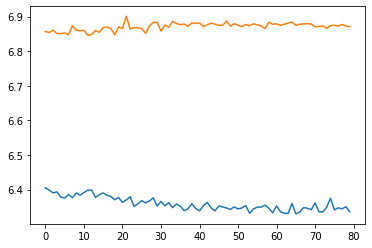

In [44]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

In [45]:
validation_score=model.evaluate_generator(val_gen)

In [47]:
hist.history.keys()

dict_keys(['val_loss', 'val_age_output_loss', 'val_imagequality_output_loss', 'val_emotion_output_loss', 'val_carryingbag_output_loss', 'val_weight_output_loss', 'val_footwear_output_loss', 'val_gender_output_loss', 'val_bodypose_output_loss', 'val_age_output_accuracy', 'val_imagequality_output_accuracy', 'val_emotion_output_accuracy', 'val_carryingbag_output_accuracy', 'val_weight_output_accuracy', 'val_footwear_output_accuracy', 'val_gender_output_accuracy', 'val_bodypose_output_accuracy', 'loss', 'age_output_loss', 'imagequality_output_loss', 'emotion_output_loss', 'carryingbag_output_loss', 'weight_output_loss', 'footwear_output_loss', 'gender_output_loss', 'bodypose_output_loss', 'age_output_accuracy', 'imagequality_output_accuracy', 'emotion_output_accuracy', 'carryingbag_output_accuracy', 'weight_output_accuracy', 'footwear_output_accuracy', 'gender_output_accuracy', 'bodypose_output_accuracy'])

In [57]:
model.save_weights('model_valid_28thDec_before_removing_dropout.h5')

###  Final validation accuracy numbers

In [60]:
{n:s for s,n in zip(validation_score,model.metrics_names) if re.search(r'accuracy',n)}

{'age_output_accuracy': 0.4254032373428345,
 'imagequality_output_accuracy': 0.5806451439857483,
 'emotion_output_accuracy': 0.7016128897666931,
 'carryingbag_output_accuracy': 0.6824596524238586,
 'weight_output_accuracy': 0.6537298560142517,
 'footwear_output_accuracy': 0.6844757795333862,
 'gender_output_accuracy': 0.9173387289047241,
 'bodypose_output_accuracy': 0.8684476017951965}